In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("lab06.ipynb")

# Lab 6: GLMs and the Bootstrap
Welcome to the Data 102 Lab 6. In this lab, we are going to look at a variety of topics including model selection, confidence intervals and credible intervals, the bootstrap, and hypothesis testing. The lab assignment may seem long, but there are only a few simple lines of code to fill in in this lab assignment. There is a lot of text in this assignment. Please make sure you read carefully.

#### The code and responses you need to write are represented by `...`. There is additional documentation for each part as you go along.

##### Please read carefully the introduction and the instructions for each problem.

## Collaboration Policy
You can submit the lab in pairs (groups of two, no more than two). **If you choose to work in a pair, please make sure to add your group member on Gradescope for both Lab 06 written submission and the Lab 06 code submission.**

Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually and do not share your code with anyone other than your partner**. If you do discuss the assignments with people other than your partner please **include their names** in the cell below.

**Collaborators:**

## Submission

Again, since this lab involves sampling, **tests may take awhile to run. Submit as early as possible, as last minute submissions may overwhelm datahub, preventing yourself and others from submitting on-time.** 

**For full credit, this assignment should be completed and submitted before Wednesday, Mar 5th, 2025 at 05:00 PM PST.**

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive
import itertools
import hashlib
from scipy.stats import poisson, norm, gamma
#!pip install pymc3
import statsmodels.api as sm
  
sns.set(style="dark")
plt.style.use("ggplot")

from pymc import *
import pymc as pm
import bambi as bmb
import arviz as az

### Load the data

In [3]:
# No need to modify: Just run the code to load the data
data_source = "hurricane_data.csv"
df = pd.read_csv(data_source)
df = df[["Year", "Num_Storms", "Temp_Anomaly"]]
df.tail()

,Year,Num_Storms,Temp_Anomaly
135,2015,11,1.28
136,2016,15,1.12
137,2017,17,1.10
138,2018,15,1.07
139,2019,18,1.24


### Model Specifications

The `Num_Storms` column contains the number of named storms recorded each year between 1880 and 2019. The `Temp_Anomaly` column contains the deviation in yearly SST from the mean of 1951-1980.

As in Lab 5, we will model the number of named storms in Year $i$ using **Poisson Regression**:

$$\lambda_i = e^{q_0 + q_1 X_i}$$ 

$$C_i \sim \text{Poisson}(\lambda_i),$$

where $X_i$ is the SST deviation in Year $i$, and $C_i$ is the number of named storms in year $i$.

## 1(a) Posterior Predictive Checks

In order to validate our Bayesian model we perform Posterior Predictive Checks (PPC). After performing Bayesian Regression we have access to a generating distribution for counts $C'_i|X_i$. The crux of PPC is to sample such counts and to compare them to the original historical data.

The code below computes PPC samples and plots their distribution. Note that here, $C$ has been renamed $y$, and the band labeled "Posterior predictive $y$" is a collection of curves, each of which is the density plot of $y$ for a given draw of the coefficient vector $\beta$ from the posterior. 

Specifically to generate a red line we follow these steps: First, we take one of our posterior samples of $q_0$ and $q_1$. Then we draw samples from the distribution $p(Y_i| q_0,q_1, X_i)$ for each data point $X_i$. Then we plot the density of the resulting $Y$'s.

In [4]:
# No need to modify
with pm.Model() as poisson_model:
    q0 = pm.Flat('q0') # SOLUTION
    q1 = pm.Flat('q1') # SOLUTION

    lam = np.exp(q0 + q1 * df['Temp_Anomaly']) # SOLUTION
    
    y = pm.Poisson('y', mu=lam, observed=df['Num_Storms']) # SOLUTION

    # DO NOT CHANGE THE SAMPLING ROUTINE
    trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [q0, q1]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [y]


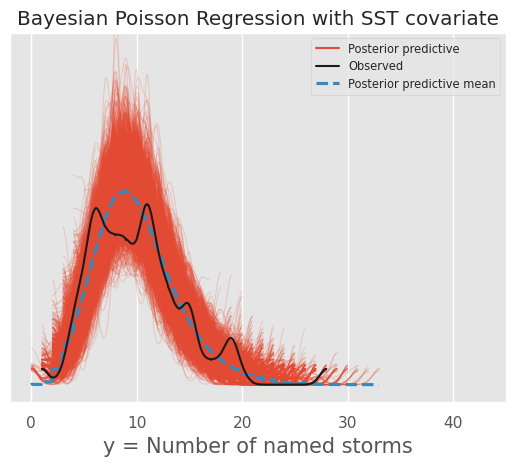

In [5]:
# Do not modify
# Sample C'_i|X_i 
with poisson_model:
    poisson_ppc = pm.sample_posterior_predictive(trace_poisson)
    poisson_ppc.posterior_predictive['y'] = poisson_ppc.posterior_predictive['y'] + 0.0
    poisson_ppc.observed_data['y'] = poisson_ppc.observed_data['y'] + 0.0
    #poisson_ppc['y'] = poisson_ppc['y'] + 0.0
    #ppc_poisson = poisson_ppc.posterior_predictive
        
# Plot PPC samples

az.plot_ppc(poisson_ppc)
plt.xlabel('y = Number of named storms')
plt.title('Bayesian Poisson Regression with SST covariate')
plt.axis([-2, 45, -0.01, 0.2])

plt.show()

In [6]:
poisson_ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

To check how important the SST (our data $X_i$) is to the results above, we can estimate a new Bayesian model which doesn't use the covariates $X_i's$, and instead uses a simple conjugate prior.

This simple model is implemented below.

In [7]:
# No TODOs here: Just inspect the code and make sure you understand what is happening
with pm.Model() as simple_bayes_model:
    mu = pm.Gamma('mu', alpha=10, beta=1)
    counts = pm.Poisson('C', mu=mu, observed=df.Num_Storms)
    simple_trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Sampling: [C]


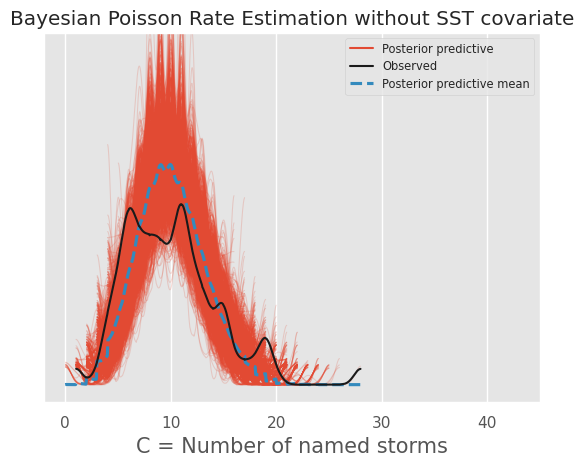

In [8]:
# Do not modify
# Sample C'_i
with simple_bayes_model:
    simple_bayes_ppc = pm.sample_posterior_predictive(simple_trace_poisson)
    simple_bayes_ppc.posterior_predictive['C'] = simple_bayes_ppc.posterior_predictive['C'] + 0.0
    simple_bayes_ppc.observed_data['C'] = simple_bayes_ppc.observed_data['C'] + 0.0
    #ppc_poisson = poisson_ppc.posterior_predictive
        
# Plot PPC samples

az.plot_ppc(simple_bayes_ppc)
plt.xlabel('C = Number of named storms')
plt.title('Bayesian Poisson Rate Estimation without SST covariate')
plt.axis([-2, 45, -0.01, 0.2])
plt.show()

<!-- BEGIN QUESTION -->

### 1(a)(i) With and without SST

Compare the two plots above. In your opinion, which model is a better fit for the observed data?

The Poisson model with SST covariate is a better fit because it accounts for external temperature anomalies, leading to more accurate and flexible predictions. The simple model fails to capture variability, reinforcing the importance of including SST as a predictor

<!-- END QUESTION -->

# Part II: Bootstrap and Hypothesis Testing

And now for something completely different. In the following questions, we are going to experiment with bootstrap and hypothesis testing. You will learn about non-parametric density estimation and the critical role of smoothing. 

## Goal: testing for multimodality
Suppose that $X_1, . . . , X_n$ are i.i.d. samples from a distribution with continuous density $p(x)$.
One important property of the density $p(x)$ is the number of modes it has. Multimodality of
the density indicates a heterogeneity in the data. In this lab, we will demonstrate how to perform a hypothesis test to determine whether a distribution is multimodal. We'll use the Bootstrap Method to perform this hypothesis test.

## Galaxy data

We will be working with galaxy data. The dataset contains velocities in km/sec of 82 galaxies from 6 well-separated conic sections of an unfilled survey
of the Corona Borealis region. The distribution
of galaxy velocities provides information about the structure of the far universe—in
particular, a multimodal distribution of velocities is seen as evidence for the existence
of voids and superclusters (links to wikipedia pages on [voids](https://en.wikipedia.org/wiki/Void_(astronomy)) and [superclusters](https://en.wikipedia.org/wiki/Supercluster)).

Let $X_1, . . . , X_{n}$ be the velocities of each galaxy, where $X_i$ is the velocity of the $i$th galaxy and we observe $n=82$ galaxies.

We want to test whether or not the distribution that the $X_i$'s are drawn from is multimodal. Let the null and alternative hypotheses be defined as follows:

$$H_0: m(p) = 1$$ 
$$H_A: m(p) > 1$$ 

where $p$ is the distribution of galaxy velocities, and $m(p)$ is the number of modes of a distribution $p$.

The formal definition of a mode will be given in Question 3 below. For now, just think of a mode as a distinct "hump" of the distribution.

## Load the data

First, we'll load the data and see what the histogram looks like.

In [9]:
galaxies_df = pd.read_csv('galaxies.csv', index_col=0, header=0, names=['velocity'])
# Divide all entries by 1000 for ease of reading.
galaxies_df['velocity'] = galaxies_df['velocity'] / 1000
X_observed = np.array(galaxies_df['velocity'])
galaxies_df.head()

,velocity
1,9.172
2,9.350
3,9.483
4,9.558
5,9.775


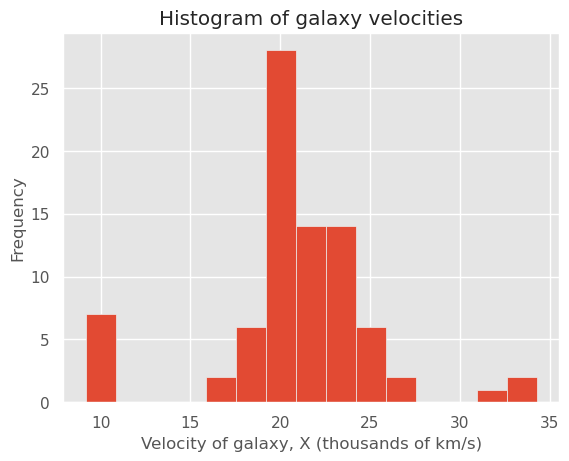

In [10]:
plt.hist(X_observed, bins=15)
plt.title("Histogram of galaxy velocities")
plt.xlabel("Velocity of galaxy, X (thousands of km/s)")
plt.ylabel("Frequency")
plt.show()

Note that from our quick glance at the histogram, it looks like there are approximately three modes. One around 10, one around 20, and one around 32. In the remainder of the lab, we'll test for multiple modes formally with a hypothesis test. 

# Question 2. Estimating the density and test statistic

In order to infer whether or not the $X_1,...,X_{n}$ were drawn from a multimodal distribution, we need to come up with a test statistic that reflects how suitable a unimodal distribution is for
modeling this data. 

To do this, we first need to come up with a model for the density function itself. In this lab you will have the chance to learn about a non-parametric density estimatation technique called *kernel density estimation*. This was also covered briefly in Data 100. To revisit the concept, see [data 100 textbook](https://www.textbook.ds100.org/ch/11/viz_smoothing.html).

#### Kernel Density Estimation
Given a set of points $X_1, X_2, \ldots, X_n \sim p(x)$. The goal of Kernel Density Estimation is to estimate the density $p(x)$ via a function $\hat{p}_h(x)$ of the form:

\begin{align}
\hat{p}_h(x) = \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) 
\end{align}
 

The function $K$ is a non-increasing function that takes only non-negative values. These functions are known as kernel functions. They are often used to capture the influence of each data point $X_i$ on the density of an arbitrary point $x$. A common choice of kernel is the Gaussian kernel, which is what we will use in this lab: 

$$K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$$

In addition, the parameter $h > 0$ is a bandwidth parameter that captures how close data points $X_i$ must be to $x$ to influence its density: for larger values of $h$, more data points have an
influence on the density at $x$, whereas for smaller values of $h$, only data points very close
to $x$ influence it.

It can be shown that the number of modes of $\hat{p}_h(x)$ (a.k.a. $m(\hat{p}_h(x))$) decreases monotonically as $h$ increases. Therefore, $h$ will be an important tool in our hypothesis test.

## 2.a. Plot the density estimates $\hat{p}_h(x)$

Using the kernel function $K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$, we will first plot $\hat{p}_h(x)$ to get a sense of what these density estimates look like for different values of $h$.

\begin{align*}
\hat{p}_h(x) &= \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
&= \frac{1}{nh \sqrt{2\pi}} \sum_{i=1}^n \exp\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
\end{align*}

Using the final simplified form above, implement a function that calculates $\hat{p}_h(x)$ at a given point $x$.

In [11]:
from math import pi, exp, sqrt
def p_hat(x, h, X):
    """Calculates p_hat(x) at a single point x, where the bandwidth of the kernel function is h.
    
    Inputs: 
      x : float, point at which to evaluate the function p_hat.
      h : float, bandwidth parameter in kernel function.
      X : array of floats of length n containing the observed galaxy velocities.
      
    Outputs:
      y: float, the value of p_hat(x) at the given point x.
    """
    n = len(X)
    coefficient = 1/ (n * h * sqrt(2 * pi))
    summation = sum(exp(-((x - Xi) **2) / (2 * h ** 2)) for Xi in X)

    return coefficient * summation

In [12]:
grader.check("q2a")

q2a results: All test cases passed!

In [13]:
# No need to modify: Just run this cell after you pass the validation tests above
def plot_density_estimate(h):
    x_values = np.arange(0, 45, 0.5)
    y_values = [p_hat(x, h, X_observed) for x in x_values]
    fig = plt.figure(figsize=(9,6))
    plt.hist(X_observed, bins=15, density=True, label="Histogram of observed values")
    plt.plot(x_values, y_values, label = "Estimated kernel density")
    plt.title("Density $\hat{p}_h(x)$")
    plt.ylabel("Density $\hat{p}_h(x)$")
    plt.xlabel("Velocity, x")
    plt.legend()
    plt.show()

In [14]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_density_estimate, h=(0.1, 4, 0.1))
interactive_plot 

interactive(children=(FloatSlider(value=2.0, description='h', max=4.0, min=0.1), Output()), _dom_classes=('wid…

<!-- BEGIN QUESTION -->

## 2.b. Questions:
### (i) Start with a small value of $h=0.1$, then slide the value of $h$, what do you observe? 

When $h$ is small, the KDE closely follows the histogram, capturing sharp peaks and reflecting the multimodal structure of the data. However, this results in overfitting, where the estimate captures noise rather than the true underlying distribution. As $h$ increases, the KDE becomes smoother, and smaller peaks gradually disappear. With a sufficiently large $h$, the density estimates converge to an unimodal shape, potentially obscuring meaningful multimodal features.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### (ii) Does the density estimate $\hat{p}_h(x)$ seem to contain more modes for higher values of $h$ or lower values of $h$?

The density estime $\hat{p}_h(x)$ contains more mode for lower values of $h$. When $h$ is small, the KDE closely follows the data, capturing many local peaks and reflecting the finer structure of the distribution. As $h$ increases, the density estimate becomes smoother, and small modes disappear eventually leading to a unimodal shape at sufficiently large $h$.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### (iii) For what values of $h$ (small or large), does $\hat{p}_h(x)$ fit the current data more closely? Would this value generalize well to other unseen data?

The density estimate $\hat{p}_h(x)$ fits the current data more closely for small values of $h$ because it captures fine details and individual variations in the dataset. However, this results in overfitting, meaning it may not generalize well to unseen data.

A large $h$ oversmooths the density, potentially missing meaningful structure, but it generalizes better by reducing noise. A moderate $h$ balances these trade-offfs, ensuring a good fit while maintaining generalizability.  

<!-- END QUESTION -->

# Question 3. Count the modes of $\hat{p}_h(x)$

### There are no todo's in this question except for a simple fill-in-the-blank question at the end. Make sure you read through the questions and understand the solutions before you move on.

Now we will write a function that counts the number of modes of a given density estimate $\hat{p}_h(x)$. This is the $m(p)$ function mentioned above. 

To do this, we say that a density function $p$ has a mode everywhere the function $p(x)$ has an increase followed by a decrease. That is, $p(x)$ has an additional mode for each time the derivative of the function $p(x)$ transitions from non-negative to negative.

Following the above definition, to count the number of modes in $\hat{p}_h(x)$, first we will take the derivative, $$\frac{d}{dx}\hat{p}_h(x).$$

Then, we will count the number of times that the derivative transitions from positive (or 0) to negative over a grid of $x$'s.

## 3.a. Calculate the derivative $\frac{d}{dx}\hat{p}_h(x).$

Using the kernel function $K(x) = \frac{1}{\sqrt{2\pi}} \exp(-x^2/2)$, we will now calculate the derivative $\frac{d}{dx}\hat{p}_h(x)$ by applying the chain rule.

\begin{align*}
\frac{d}{dx}\hat{p}_h(x) &= \frac{d}{dx} \frac{1}{nh} \sum_{i=1}^n K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{d}{dx} K\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh} \sum_{i=1}^n \frac{1}{h} K'\left(\frac{x - X_i}{h}\right) \\
&= \frac{1}{nh^2} \sum_{i=1}^n \frac{1}{\sqrt{2\pi}} \frac{-(x - X_i)}{h} \exp
\left(-\frac{\left(\frac{x - X_i}{h}\right)^2}{2}\right) \\
&= \frac{1}{nh^3 \sqrt{2\pi}} \sum_{i=1}^n (X_i - x)\exp
\left(-\frac{(x - X_i)^2}{2h^2}\right) \\
\end{align*}

### Using the final simplified form of the derivative above, we will then implement a function that calculates $\frac{d}{dx}\hat{p}_h(x)$ at a given point $x$.

In [15]:
def p_hat_derivative(x, h, X):
    """Calculates the derivative d/dx p_hat(x) at a single point x.
    
    Inputs: 
      x : float, point at which to evaluate the derivative.
      h : float, bandwidth parameter in p_hat.
      X : array of floats of length n containing the observed galaxy velocities.
      
    Outputs:
      y_prime : float, the derivative d/dx phat_h(x) at the given point x.
    """
    n = len(X)
    total = np.sum((X - x) * np.exp(-((x - X)**2) / (2 * h**2)))
    y_prime = total / (n * h**3 * sqrt(2 * pi))
    return(y_prime)

In [16]:
# No need to modify: Just run this cell after you pass the validation tests above
def plot_density_derivative(h):
    x_values = np.arange(4, 36, 0.5)
    y_values = [p_hat_derivative(x, h, X_observed) for x in x_values]
    fig = plt.figure(figsize=(9,6))
    plt.plot(x_values, y_values)
    plt.axhline(0, c = 'k', ls = "--")
    plt.title("Derivative of the density $\hat{p}_h(x)$")
    plt.xlabel("Velocity, x")
    plt.show()

In [17]:
# Visualize interactive plot: Do not modify
interactive_plot = interactive(plot_density_derivative, h=(0.1, 4, 0.1))
interactive_plot 

interactive(children=(FloatSlider(value=2.0, description='h', max=4.0, min=0.1), Output()), _dom_classes=('wid…

We notice that when $h$ is really small the derivative is very 'wiggly' and it frequently crosses the 0 line. As $h$ increases, it crosses the 0 line less frequently.

## 3.b. Count the number of modes in $\hat{p}_h(x)$

Using the derivative calculated above, we will now count the number of modes in $\hat{p}_h(x)$.

To do this, we will evaluate the derivative $\frac{d}{dx}\hat{p}_h(x)$ at a grid of points $x_1,...,x_m$ evenly spaced between $5$ and $35$ (the lower and upper bounds on the velocities in the data), and count the number of times that the derivative crosses from positive to negative.  The use of a grid of $x$'s isn't a perfect measurement of the mode count, since if we don't evaluate the derivative at enough points that are close enough together, we may miss some modes. In this lab, we will make sure that the grid we use is fine enough to accurately count the number of modes.

In [18]:
# Count the modes of phat using the derivative implemented above.
def count_modes(x_values, h, X):  
    """Counts the number of modes in p_hat(x), approximated over the given grid of x_valies.
    
    Counts a mode every time the derivative of p_hat(x) crosses from positive (or 0)
    to negative over the given grid of x_values.
    
    Inputs: 
      x_values : array of floats of length m 
      containing points at which to evaluate the derivative.
      h: float, bandwidth parameter in phat_h.
      X: array of floats of length n containing the observed galaxy velocities.
      
    Outputs:
      num_modes : int, the number of modes in p_hat(x).
    """
    # First calculate the derivative at all points in x_values.
    all_derivatives = [p_hat_derivative(x, h, X) for x in x_values]
    
    # Iterate through all of the calculated derivatives, 
    # and add a mode every time the derivative crosses from positive (or 0) to negative.
    num_modes = 0
    for i in range(0, len(all_derivatives)-1):
        if (all_derivatives[i] >= 0) and (all_derivatives[i + 1] < 0):
            num_modes += 1
    
    return num_modes

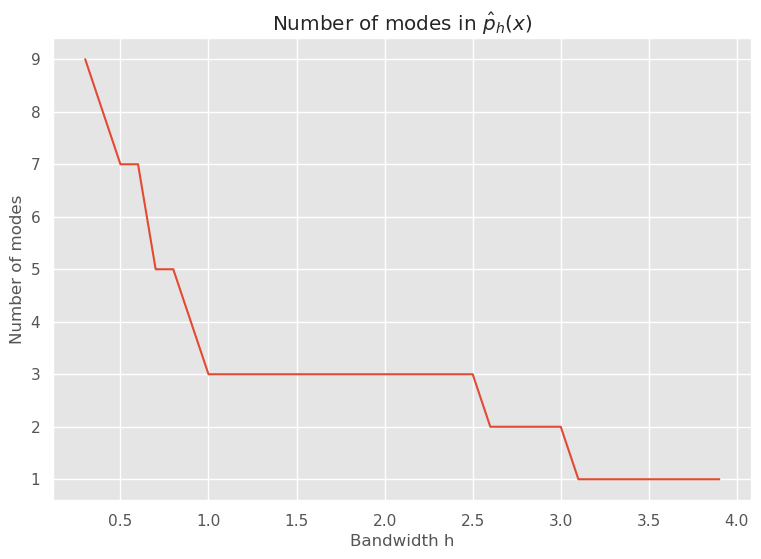

In [19]:
# No need to modify: Plot the number of modes for different values of h.
# This cell may take a few seconds to run.
x_values = np.arange(5,35,0.05)
h_values = np.arange(0.3,4,0.1)
mode_counts = [count_modes(x_values, h, X_observed) for h in h_values]

fig = plt.figure(figsize=(9,6))
plt.plot(h_values, mode_counts)
plt.title("Number of modes in $\hat{p}_h(x)$")
plt.ylabel("Number of modes")
plt.xlabel("Bandwidth h")
plt.show()

<!-- BEGIN QUESTION -->

## 3.c. (To-do) Fill-in-the-blanks
Based on your observation above, we can develop a stategy to find the number of modes. Fill in the blanks below.

"*To find the number of modes, we evaluate the (**Blank 1**)  on a grid of points, and count the number of times it goes from (**Blank 2**) to (**Blank 3**)."*

1. derivative $\frac{d}{dx} \hat{p}_h (x)$
2. positive (or 0)
3. negative

<!-- END QUESTION -->

# Question 4. Hypothesis test

Now that we've defined the density estimate $\hat{p}_h(x)$ and figured out how to count the number of modes in $\hat{p}_h(x)$, we will move on to testing whether or not a multimodal distribution can reasonably fit our data $X_1,...,X_n$.

In the plot in part 2.b. you should have observed that the number of modes in $\hat{p}_h(x)$ decreases monotonically as $h$ increases. Let $H_1$ be the minimal bandwidth value $h$ for which $\hat{p}_h(x)$ is unimodal. 

\begin{align}
    H_1 & = \min \{h \colon m(\hat{p}_h) = 1, \, m(\hat{p}_{h'}) > 1 \text{ for all } h' < h\}.
\end{align}

Similarly we define $H_k$ to be the minimal bandwidth value $h$ for which $\hat{p}_h(k)$ has $k$ modes:

\begin{align}
    H_k & = \min \{h \colon m(\hat{p}_h) = k, \, m(\hat{p}_{h'}) > k \text{ for all } h' < h\}.
\end{align}

We will use $H_k$ as the test statistic. 

Notice that $H_k$ depends on the data $X$, because the function $\hat{p}_h(x)$ depends on the data $X$.

For our particular observed dataset $X_{observed}$, let $h_k$ be the observed minimal bandwidth value $h$ for which $\hat{p}_h(x)$ has $k$ modes.


## Calculate $H_k$
The first thing we need to do is calculate $H_k$ for a given dataset $X$. To do this, we will try different values of $h$ until we find the smallest value such that the density estimate $\hat{p}_h$ has $k$ modes. The function below accomplishes that. Take a few minutes to examine it and understand what it is doing.

In [20]:
# No TODOs here, just understand what this function is doing.
def find_hk(x_values, X, h_min=0.3, h_max=4, h_err = 0.01, k=1):
    """
    Calculates h_k, the minimum bandwidth h such that the density estimate p_hat has k modes.
    Chooses h_k from within an interval bounded by h_min and h_max, within error h_err.
    
    Inputs:
      x_values: array of floats containing points x to use to count the number of modes in p_hat.
      X: array of floats of length n containing the observed galaxy velocities.
      h_min: float, minimum h to try.
      h_max: float, maximum h to try.
      h_err: float, allowed error of h, or step size of hs to try between h_min and h_max.
      k: number of modes being tested in the hypothesis test.
      
    Returns:
      h_k: minimum bandwith h among candidate h_values such that p_hat has k modes.
    """
    # Perform a binary search to find the minimum bandwith hk.
    h_opt = 0
    modes_min = count_modes(x_values, h_min, X)
    modes_max = count_modes(x_values, h_max, X)
    while h_max - h_min > h_err:
        h_opt = (h_min + h_max) / 2
        modes_opt = count_modes(x_values, h_opt, X)
        if modes_opt > k:
            h_min = h_opt
            modes_min = modes_opt
        else:
            h_max = h_opt
            modes_max = modes_opt
    return h_max

The function above calculates the test statistic $H_k$. To calculate the value $h_1$ for the null hypothesis, we apply this same function over the observed data $X_1,...,X_n$. Run the cell below and compare the outputs with the plot in 2.b.

In [21]:
# No TODOs here, just run this cell to calculate the value of h_k using the function above.
# This cell might take a minute or so to run
x_values = np.arange(5,35,0.05)
for k in range(1,10):
    hk = find_hk(x_values, X_observed, k=k)
    print("For k = {}. Estimate value of h_{}: {:.4f}".format(k, k, hk))

For k = 1. Estimate value of h_1: 3.0461
For k = 2. Estimate value of h_2: 2.5041
For k = 3. Estimate value of h_3: 0.9359
For k = 4. Estimate value of h_4: 0.8854
For k = 5. Estimate value of h_5: 0.6758
For k = 6. Estimate value of h_6: 0.6686
For k = 7. Estimate value of h_7: 0.4518
For k = 8. Estimate value of h_8: 0.3650
For k = 9. Estimate value of h_9: 0.3072


##  Computing the $p$-value

Let's say we are trying to test if the distribution of galaxies' velocities is unimodal. The corresponding test statistic is $H_1$ and the observed realization is $h_1$. Therefore, the $p$-value for our hypothesis test is: 

$$P_{0}(H_1 \geq h_1)$$

where $P_0$ is the probability under the null hypothesis that the $X_i$ are drawn from a unimodal distribution. This $p$-value represents the probability under the null hypothesis that we observe a value as extreme as $h_1$ for the minimum width parameter.

To perform a hypothesis test at significance level $\alpha$, we reject the null hypothesis if the $p$-value is less than $\alpha$:
$$P_{0}(H_1 \geq h_1) \leq \alpha. $$

Now, we need to calculate the $p$-value. Unfortunately, we don't have a closed form for the distribution of the test statistic $H_1$ under the null hypothesis that the $X_i$ are drawn from a unimodal distribution. In fact, we don't even know what distribution the $X_i$ are drawn from, only that it's unimodal (under the null hypothesis)! Still, to estimate the distribution of the test statistic $H_1$, we need to pick some distribution to use for the distribution of the $X_i$'s under the null hypothesis.

Among the parameterized densities $\hat{p}_h(x)$, the density $\hat{p}_{h_1}(x)$ is the closest unimodal distribution  to the empirical distribution $p$ of the observed data. So, we will use $\hat{p}_{h_1}(x)$ as the distribution of the $X_i$'s under the null hypothesis.

Therefore, the $p$-value that we will calculate is $$P_{X_i \sim \hat{p}_{h_1}}(H_1 \geq h_1).$$

More generally, if instead we want to test if the distribution of galaxies' velocities has at most $k$ modes can be calculated as:
$$P_{0}(H_k \geq h_k) \approx P_{X_i \sim \hat{p}_{h_k}}(H_k \geq h_k)$$

##  4.a. Sampling from $\hat{p}_{h_k}$ using the Bootstrap Method

To calculate the $p$-value, we will first draw i.i.d. samples from $\hat{p}_{h_k}$, and then observe the number of times that the $H_k$ calculated from those samples is greater than or equal to $h_k$. We will use the bootstrap to draw the i.i.d. samples from $\hat{p}_{h_k}$.

Let $Z^{*} = (Z_1^*, \ldots, Z_{82}^*)$ denote a bootstrap sample from the dataset $X_{observed}$. It can be shown that by adding some scaled noise to the bootstrap samples we can obtain samples from the null distribution. More precisely: 
$Z_i^* + h_k \epsilon_i$ for $\epsilon_i \sim \mathcal{N}(0, 1)$ gives i.i.d. samples from $\hat{p}_{h_k}$.

This leads to the following bootstrap algorithm: 

1. Draw $B$ independent bootstrap samples $Z^{*(1)}, \ldots, Z^{*(B)}$ from the observed data. Then add some noise to get samples  $X^{*(1)}, \ldots, X^{*(B)}$ from the null distribution $\hat{p}_{h_1}$:
    \begin{align}
        X_i^{*(b)} & = Z_i^{*(b)} + h_k \epsilon_i^{(b)} \\
        \epsilon_i^{(b)} & \sim \mathcal{N}(0, 1)
    \end{align}
    
    However, since the variance of the bootstrap sample has been increased by adding the normal error term, the data are usually rescaled to have the same sample variance as the original observations. So, we replace the equation above in the algorithm with 
    
    \begin{align}
        X_i^{*(b)} & = \bar{Z}^{*(b)} + (1 + h_k^2/\hat{\sigma}^2)^{-1/2} (Z_i^{*(b)} - \bar{Z}^{*(b)} + h_k\epsilon_i^{(b)}).
    \end{align}
    
    We'll use this more complicated variance scaling in the code. In the equation above we have:
    - $\bar{Z}^{*(b)}$ is the sample mean of the bootstrap samples $Z^{*(b)}$.
    - $\hat\sigma$ is the variance of the original observed data.
    - $h_k$ is the minimum bandwidth h such that the density estimate for the original observed data has k modes.
    - $\epsilon_i^{(b)} \sim \mathcal{N}(0, 1)$, iid Gaussian noise
    
   We will call $ X_i^{*(b)}$ **bootstrap replicates**. 
       
       
       
2. For each bootstrap replicate $X^{*{b}}$, evaluate the value of the test statistic $H_k^{*(b)}$.
    
3. Estimate the $p$-value as the fraction of time that the value of the test statistic evaluated on the bootstrap replicates is larger the the test statistic evaluated on the original observed data.
    \begin{align}
        \text{estimate of }  \mathbb{P}_0(H_k \geq h_k) = \frac{1}{B} \sum_{b = 1}^B 1[H_k^{*(b)} \geq h_k].
    \end{align}
    

First, you'll write some code to draw bootstrap samples.

In [28]:
def draw_Z_star(X):
    """Resample (with replacement) a new array the same length as X 
    
    Inputs: 
      X: array of floats containing the observed galaxy velocities
    
    Outputs:
      Z_star: array of floats resampled from X with replacement
      Z_bar: the mean of Z_star
    """

    # TODO: obtain the bootstrap sample Z_star, and its mean Z_bar
    # Z_star should be an array of n samples drawn from the data array X, sampled with replacement.
    # Hint: use np.random.choice.
    Z_star = np.random.choice(X, size=len(X), replace=True)
    Z_bar = np.mean(Z_star)
    return Z_star, Z_bar

In [29]:
grader.check("q4a")

q4a results: All test cases passed!

Then, we will calculate the p-values using these bootstrap samples:

In [30]:
# No TODOs here
def estimate_p_value(X, B, k=1):
    """Estimates the p-value for the hypothesis test.
    
    Inputs: 
      X: array of floats containing the observed galaxy velocities.
      B: int, number of bootstrap samples to draw.
      k: int, number of modes we are testing for.
    
    Outputs:
      p_value: float, an estimate of the p-value.
    """
    # Find hk for the distribution under the null hypothesis.
    x_values = np.arange(5,35,0.05)
    hk = find_hk(x_values, X, k=k)
    # Count of the number of times Hk >= hk.
    Hk_greater_count = 0
    # Variance of the observed data X for rescaling the data.
    X_var = np.var(X)
    n = len(X)
    for _ in range(B):
        Z_star, Z_bar = draw_Z_star(X)
        
        epsilon = np.random.normal(size=n)
        X_star = Z_bar + (1 / sqrt(1 + ((hk**2) / X_var))) * (Z_star - Z_bar + (hk * epsilon)) # TODO: fill in
        
        # Check if H1 >= h1. Instead of explicitly calculating H1 (which could take long), 
        # we are using a shortcut where we count the number of modes in X_star under bandwidth value h1.
        # If the counted number of modes is greater than the number of modes used to find h1 
        # for the observed data, then the bandwidth value H1 is greater than or equal to the bandwidth value h1.
        # This is true because of number of modes is monotonically decreasing in the bandwidth value h.
        modes = count_modes(x_values, hk, X_star)
        if modes > k:
            Hk_greater_count += 1
    p_value = Hk_greater_count / B 
    return(p_value)

## Try testing for different numbers of modes.

If we reject the hypothesis that the distribution of the data has 1 mode, what about testing if the distribution has more than $k$ modes? We can apply the same techniques to test 

$$H_0: m(p) = k$$ 
$$H_A: m(p) > k$$ 

Below, we apply the same techniques to estimate the $p$-values for $k = 2$ and $k = 3$.

In [31]:
# No TODOs here, run this cell to calculate the p-value. 
p_val_1 = estimate_p_value(X_observed, 100, k=1)
print("p-value for test for more than 1 mode:", p_val_1)

p-value for test for more than 1 mode: 0.0


In [32]:
# No TODOs here, run this cell to calculate the p-value.
# k = 2
p_val_2 = estimate_p_value(X_observed, 100, k=2)
print("p-value for test for more than 2 modes:", p_val_2)

p-value for test for more than 2 modes: 0.0


In [33]:
# No TODOs here, run this cell to calculate the p-value.
# k = 3
p_val_3 = estimate_p_value(X_observed, 100, k=3)
print("p-value for test for more than 3 modes:", p_val_3)

p-value for test for more than 3 modes: 0.49


<!-- BEGIN QUESTION -->

### 4.b. For which values of $k$ were you able to reject the null hypothesis? Did this match your expectation of the number of modes in the data based on looking at the initial histogram?

We were able to reject the null hypothesis for k=1 and k=2, meaning the data does not appear to be unimodal or bimodal, However, for k $\geq 3$, we failed to reject the null hypothesis, suggesting that the data is at least trimodal. The results align with our expectations based on the initial histogram, which displayed multiple peaks, indicating the prescence of more than two modes in the distribution.

<!-- END QUESTION -->



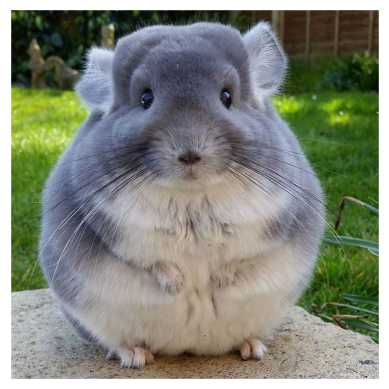

In [36]:
import matplotlib.image as mpimg
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
export_notebook("lab06.ipynb", filtering=True, pagebreaks=True)
if(path.exists('lab06.pdf')):
    img = mpimg.imread('chinchilla.jpg')
    imgplot = plt.imshow(img)
    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)
    plt.show()
    display(HTML("Download your PDF <a href='lab06.pdf' download>here</a>."))

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [37]:
grader.check_all()

q2a results: All test cases passed!

q4a results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit.

In [38]:
grader.export(pdf=False, force_save=True)

<IPython.core.display.Javascript object>